# Goal

Use time series analysis to project future traffic patterns 

## Dataset
Traffic Flow Data Jan to June 2022 SDCC
https://data.gov.ie/dataset/traffic-flow-data-jan-to-june-2022-sdcc

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('Traffic_Flow_Data.csv')

In [3]:
data.head()

,site,day,date,start_time,end_time,flow,flow_pc,cong,cong_pc,dsat,dsat_pc,ObjectId
0,N01111A,TU,04/01/2022,2022/11/07 03:00:00+00,03:15,13,100,0,100,0,0,1
1,N01111A,TU,04/01/2022,2022/11/07 03:15:00+00,03:30,10,100,0,100,0,0,2
2,N01111A,TU,04/01/2022,2022/11/07 03:30:00+00,03:45,0,100,0,100,0,0,3
3,N01111A,TU,04/01/2022,2022/11/07 03:45:00+00,04:00,9,100,0,100,0,0,4
4,N01111A,TU,04/01/2022,2022/11/07 04:00:00+00,04:15,0,100,0,100,0,0,5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 12 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   site        1048575 non-null  object
 1   day         1048575 non-null  object
 2   date        1048575 non-null  object
 3   start_time  1048575 non-null  object
 4   end_time    1048575 non-null  object
 5   flow        1048575 non-null  int64 
 6   flow_pc     1048575 non-null  int64 
 7   cong        1048575 non-null  int64 
 8   cong_pc     1048575 non-null  int64 
 9   dsat        1048575 non-null  int64 
 10  dsat_pc     1048575 non-null  int64 
 11  ObjectId    1048575 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 96.0+ MB


## Feature Engineering

Some of this data isn't going to be beneficial for this analysis. As such, we can delete those rows and columns. 
Additionally, we might want to decomposed the date-time values 


In [5]:
# delete the values 
columns_to_drop = ['cong', 'cong_pc', 'dsat', 'dsat_pc', 'ObjectId']
data = data.drop(columns_to_drop, axis=1)

In [7]:
data['date'].info
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
data.head()

,site,day,date,start_time,end_time,flow,flow_pc
0,N01111A,TU,2022-01-04,2022/11/07 03:00:00+00,03:15,13,100
1,N01111A,TU,2022-01-04,2022/11/07 03:15:00+00,03:30,10,100
2,N01111A,TU,2022-01-04,2022/11/07 03:30:00+00,03:45,0,100
3,N01111A,TU,2022-01-04,2022/11/07 03:45:00+00,04:00,9,100
4,N01111A,TU,2022-01-04,2022/11/07 04:00:00+00,04:15,0,100


In [17]:
data['start_time'] = pd.to_datetime(data['start_time'], format='%Y/%m/%d %H:%M:%S%z')

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['start_time'].dt.hour
data['minute'] = data['start_time'].dt.minute
data['second'] = data['start_time'].dt.second

data.head()

,site,day,date,start_time,end_time,flow,flow_pc,year,month,hour,minute,second
0,N01111A,4,2022-01-04,2022-11-07 03:00:00+00:00,03:15,13,100,2022,1,3,0,0
1,N01111A,4,2022-01-04,2022-11-07 03:15:00+00:00,03:30,10,100,2022,1,3,15,0
2,N01111A,4,2022-01-04,2022-11-07 03:30:00+00:00,03:45,0,100,2022,1,3,30,0
3,N01111A,4,2022-01-04,2022-11-07 03:45:00+00:00,04:00,9,100,2022,1,3,45,0
4,N01111A,4,2022-01-04,2022-11-07 04:00:00+00:00,04:15,0,100,2022,1,4,0,0


In [18]:
unique_sites = data['site'].nunique()
print(f'Total number of unique sites: {unique_sites}')

##  61 unique sites

Total number of unique sites: 61


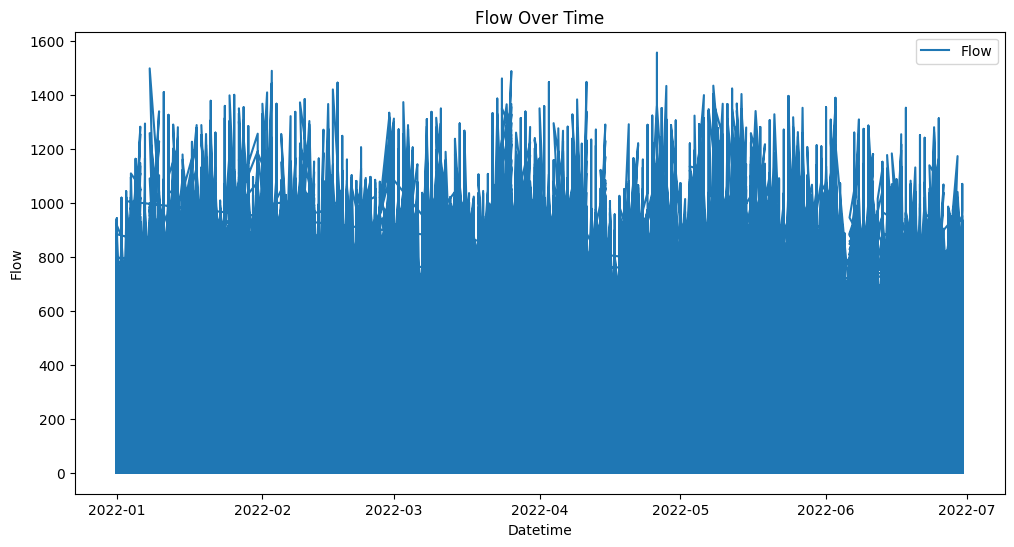

In [19]:
import matplotlib.pyplot as plt

# Assuming 'datetime_column' is the name of your datetime column
# and 'flow' is the name of your flow column
plt.figure(figsize=(12, 6))

# Plotting time data with respect to flow
plt.plot(data['date'], data['flow'], label='Flow')

plt.title('Flow Over Time')
plt.xlabel('Datetime')
plt.ylabel('Flow')
plt.legend()
plt.show()

In [20]:
# Maybe now lets just look at data for one mont... how about month 4

month_4 = data[data['month'] == 4]
month_4.head()

,site,day,date,start_time,end_time,flow,flow_pc,year,month,hour,minute,second
8400,N01111A,1,2022-04-01,2022-11-07 15:45:00+00:00,16:00,381,100,2022,4,15,45,0
8401,N01111A,1,2022-04-01,2022-11-07 16:00:00+00:00,16:15,399,100,2022,4,16,0,0
8402,N01111A,1,2022-04-01,2022-11-07 16:15:00+00:00,16:30,369,100,2022,4,16,15,0
8403,N01111A,1,2022-04-01,2022-11-07 16:30:00+00:00,16:45,437,100,2022,4,16,30,0
8404,N01111A,1,2022-04-01,2022-11-07 16:45:00+00:00,17:00,504,100,2022,4,16,45,0


In [24]:
## lets add up the total flow for the day
daily_total_flow = month_4.groupby('day')['flow'].sum().reset_index()
daily_total_flow.head()

,day,flow
0,1,846346
1,2,662972
2,3,592156
3,4,763637
4,5,796642


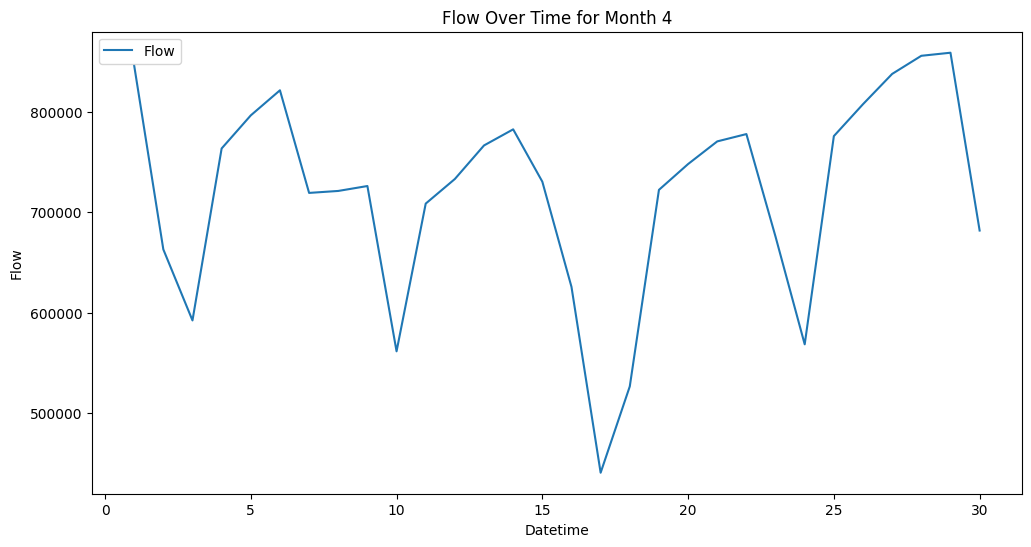

In [25]:
plt.figure(figsize=(12, 6))

# Plotting time data with respect to flow
plt.plot(daily_total_flow['day'], daily_total_flow['flow'], label='Flow')

plt.title('Flow Over Time for Month 4')
plt.xlabel('Datetime')
plt.ylabel('Flow')
plt.legend()
plt.show()

# Data Analysis

We could go many direction... 
1. forecast future traffic patterns
2. train a model to determine what time to leave based on a given traffic pattern
3. look to see if there are any anomalies